In [1]:
import itertools
import glob
import xml.etree.ElementTree as ET

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import dezero
from dezero import DataLoader, optimizers, Parameter, test_mode
import dezero.functions as F
import dezero.layers as L
from dezero.core import Variable
from dezero.models import VGG16, Model

from image_process import data_aug
from utils import train_test_split, convert_img_for_mat
from utils import write_bndbox, show_heatmap

In [2]:
class Anno_xml_to_List(object):
    def __init__(self, classes):
        self.classes = classes
    
    def __call__(self, xml_path):
        xml = ET.parse(xml_path).getroot()
        path = xml.find('path').text
        
        objects = []
        for obj in xml.iter('object'):
            #class name
            name = obj.find('name').text
            
            #coordinates of bounding_box
            bbox = obj.find('bndbox')
            bbs ={}
            for pt in ['xmin', 'ymin', 'xmax', 'ymax']:
                cur_pixel = float(bbox.find(pt).text) - 1
                bbs[pt] = cur_pixel
            objects.append({'bndbox': bbs, 'name': name})
    
        return {'path':path, "object": objects}

In [3]:
paths = glob.glob("car-PascalVOC-export/Annotations/*.xml")

train_pathes, test_pathes = train_test_split(paths)
transform_anno = Anno_xml_to_List([])
target = transform_anno(train_pathes[2])

print(target["object"])

[{'bndbox': {'xmin': 1.6187050359712232, 'ymin': 111.23021582733813, 'xmax': 196.15107913669067, 'ymax': 208.9952190591277}, 'name': 'car'}, {'bndbox': {'xmin': 207.62353164343526, 'ymin': 60.35251798561151, 'xmax': 398.1654676258993, 'ymax': 163.1055231986286}, 'name': 'car'}]


In [4]:
def convert_xyxy_to_xywh(bnd_xyxy):
    bnd_xywh = {
      "x": (bnd_xyxy['xmax'] + bnd_xyxy['xmin']) / 2,
      "y": (bnd_xyxy['ymax'] + bnd_xyxy['ymin']) / 2,
      "w": (bnd_xyxy['xmax'] - bnd_xyxy['xmin']),
      "h": (bnd_xyxy['ymax'] - bnd_xyxy['ymin'])
      }
    return bnd_xywh

def convert_xyxys_to_xywhs(bnd_xyxys):
    return [convert_xyxy_to_xywh(bnd) for bnd in bnd_xyxys]


def convert_xywh_to_xyxy(bnd_xywh):
    bnd_xyxy = {
      "xmin": bnd_xywh['x'] - bnd_xywh['w'] / 2,
      "ymin": bnd_xywh['y'] - bnd_xywh['h'] / 2,
      'xmax': bnd_xywh['x'] + bnd_xywh['w'] / 2,
      'ymax': bnd_xywh['y'] + bnd_xywh['h'] / 2,      
      }
    return bnd_xyxy

def convert_xywhs_to_xyxys(bnd_xywhs):
    return [convert_xywh_to_xyxy(bnd) for bnd in bnd_xywhs]


def resize_xyxy_bnd(bnd_xyxy, ratio=416/224):
    bnd_xyxy = {
       "xmin": bnd_xyxy['xmin'] / ratio,
       "ymin": bnd_xyxy['ymin'] / ratio,
       "xmax": bnd_xyxy['xmax'] / ratio,
       "ymax": bnd_xyxy['ymax'] / ratio
      }
    return bnd_xyxy

def resize_xyxys_bnd(target_obj, ratio=416/224):
    return [resize_xyxy_bnd(bnd['bndbox'], ratio)
          for bnd in target_obj]

bnd_xyxys = resize_xyxys_bnd(target["object"])
print(bnd_xyxys)
bnd_xywhs = convert_xyxys_to_xywhs(bnd_xyxys)
bnd_xyxys = convert_xywhs_to_xyxys(bnd_xywhs)
print(bnd_xywhs)
print(bnd_xyxys)

[{'xmin': 0.8716104039845047, 'ymin': 59.893193137797454, 'xmax': 105.61981184283343, 'ymax': 112.53588718568413}, {'xmin': 111.79728626954206, 'ymin': 32.49750968456004, 'xmax': 214.3967902600996, 'ymax': 87.8260509531077}]
[{'x': 53.24571112340897, 'y': 86.21454016174079, 'w': 104.74820143884892, 'h': 52.64269404788668}, {'x': 163.09703826482084, 'y': 60.16178031883387, 'w': 102.59950399055755, 'h': 55.32854126854765}]
[{'xmin': 0.871610403984505, 'ymin': 59.89319313779745, 'xmax': 105.61981184283343, 'ymax': 112.53588718568412}, {'xmin': 111.79728626954207, 'ymin': 32.49750968456004, 'xmax': 214.3967902600996, 'ymax': 87.8260509531077}]


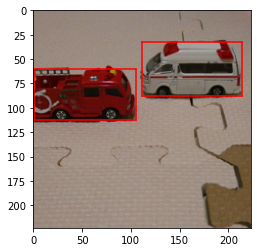

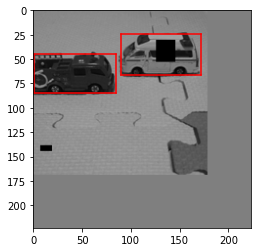

In [5]:
img = Image.open(target["path"])
bnd_xyxys = [resize_xyxy_bnd(bnd['bndbox']) for bnd in target["object"]]

img = img.resize((224, 224))
write_bndbox(img, bnd_xyxys)

bnd_xywhs = convert_xyxys_to_xywhs(bnd_xyxys)
img, bnd_xywhs = data_aug(img, bnd_xywhs)
bnd_xyxys = convert_xywhs_to_xyxys(bnd_xywhs)

write_bndbox(img, bnd_xyxys)

In [6]:
def make_target(bnd_xywhs, scale=32., imsize=224.):
    target = np.zeros([5, 7, 7], dtype=np.float32)

    for bnd_xywh in bnd_xywhs:
        x_grid = bnd_xywh["x"] // scale
        y_grid = bnd_xywh["y"] // scale
        
        x_pos = (bnd_xywh["x"] - (x_grid * scale)) / scale
        y_pos = (bnd_xywh["y"] - (y_grid * scale)) / scale
        
        width = np.sqrt(bnd_xywh["w"] / imsize)
        height = np.sqrt(bnd_xywh["h"] / imsize)
        
        #x...axis_1, y...axis_0
        target[0, int(y_grid), int(x_grid)] = 1.
        target[1, int(y_grid), int(x_grid)] = x_pos
        target[2, int(y_grid), int(x_grid)] = y_pos
        target[3, int(y_grid), int(x_grid)] = width
        target[4, int(y_grid), int(x_grid)] = height

    return target


def convert_pred_to_xywh(predict, scale=32, imsize=224, thres=0.4):
    
    y_pos, x_pos = np.where(predict[0, :, :] > thres)
    scores = []
    xywhs = []
    for x, y in zip(x_pos, y_pos):
        scores.append(predict[0, y, x])
        
        #widthとheightはmake targetでsqrtしていることに注意
        bnd_xywh = {
            "x": (x + predict[1, y, x]) * scale,
            "y": (y + predict[2, y, x]) * scale,
            "w": (predict[3, y, x] ** 2) * imsize,
            "h": (predict[4, y, x] ** 2) * imsize
            }
        xywhs.append(bnd_xywh)
    return scores, xywhs


print(bnd_xywhs)
target = make_target(bnd_xywhs)
print(target[0, :, :])
print(convert_pred_to_xywh(target))

[{'x': 42.703315165050604, 'y': 65.07760930164662, 'w': 84.00855889872452, 'h': 39.736460571586655}, {'x': 130.80460530175853, 'y': 45.412117574779984, 'w': 82.28529326112114, 'h': 41.763827599725765}]
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]
([1.0, 1.0], [{'x': 130.8046052455902, 'y': 45.41211795806885, 'w': 82.2852860515045, 'h': 41.76382824414256}, {'x': 42.703314781188965, 'y': 65.0776093006134, 'w': 84.00855848438914, 'h': 39.73645990544492}])


In [7]:
class MyDataset:
    def __init__(self, paths_xml, transform, train=True):
        self.transform = transform
        self.paths_xml = paths_xml
        self.train = train
        
    def __len__(self):
        return len(self.paths_xml)

    def __getitem__(self, index):
        transform_anno = Anno_xml_to_List([])
        img_anno = transform_anno(self.paths_xml[index])

        bnd_xyxys = resize_xyxys_bnd(img_anno["object"])
        bnd_xywhs = convert_xyxys_to_xywhs(bnd_xyxys)
        
        img = Image.open(img_anno["path"])
        img = img.resize((224, 224))
        if self.train == True:
            #先にimgをresizeしておくこと
            img, bnd_xywhs = data_aug(img, bnd_xywhs)
            
        #VGG16の前処理
        img = self.transform(img)
        target = make_target(bnd_xywhs)

        return img, target

In [8]:
class NET(VGG16):
    def __init__(self, pretrained=True):
        super().__init__(pretrained)
        self.conv6_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv6_2 = L.Conv2d(5, kernel_size=3, stride=1, pad=1)

    def forward(self, x):
        #VGG16のforwardを上書き
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conv4_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv6_1(x))
        x = F.sigmoid(self.conv6_2(x))
        return x

    
def loss_fn(pred, targets):
    mask = Variable(targets[:, 0, :, :])
    #object or background
    loss_0 = F.binary_cross_entropy(pred[:, 0, :, :],
                                    targets[:, 0, :, :])
    #グリッド内の位置
    loss_1 = F.mean_squared_error(pred[:, 1, :, :] * mask, 
                                  targets[:, 1, :, :])
    loss_2 = F.mean_squared_error(pred[:, 2, :, :] * mask, 
                                  targets[:, 2, :, :])
    #size of bounding box
    loss_3 = F.mean_squared_error(pred[:, 3, :, :] * mask,
                                  targets[:, 3, :, :])
    loss_4 = F.mean_squared_error(pred[:, 4, :, :] * mask,
                                  targets[:, 4, :, :])
    loss = (loss_0 * 0.1) + loss_1 + loss_2 + loss_3 + loss_4

    return loss

In [9]:
paths = glob.glob("car-PascalVOC-export/Annotations/*.xml")
train_paths, test_paths = train_test_split(paths)

np.random.seed(12)
train_set = MyDataset(train_paths, VGG16.preprocess, train=True)
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)

test_set = MyDataset(test_paths, VGG16.preprocess, train=False)
test_loader = DataLoader(test_set, batch_size=10, shuffle=False)

net = NET(pretrained=True)
optimizer = optimizers.AdaGrad(lr=0.0001).setup(net)

train_loader.to_gpu()
test_loader.to_gpu()
net.to_gpu()

In [10]:
train_losses = []
test_losses = []

for epoch in range(200):
    tmp_loss, tmp_data = 0., 0.
    for imgs, targets in train_loader:

        pred = net(imgs)
        loss = loss_fn(pred, targets)
        loss.backward()
        optimizer.update()
        net.cleargrads()
        
        tmp_loss += float(loss.data)
        tmp_data += imgs.shape[0]
        del(pred, loss)
        
    train_losses.append(tmp_loss/tmp_data)

    tmp_loss, tmp_data = 0., 0.
    for imgs, targets in test_loader:
        with test_mode():
            pred = net(imgs)
        loss = loss_fn(pred, targets)
        tmp_loss += float(loss.data)
        tmp_data += imgs.shape[0]
        del(pred, loss)
        
    test_losses.append(tmp_loss/tmp_data)
    
    print("epoch:",epoch, 
          " train:", np.round(train_losses[-1], 4), 
          "test:", np.round(test_losses[-1], 4))

epoch: 0  train: 0.2301 test: 0.1357
epoch: 1  train: 0.1065 test: 0.1055
epoch: 2  train: 0.0944 test: 0.0987
epoch: 3  train: 0.0911 test: 0.1004
epoch: 4  train: 0.0814 test: 0.0938
epoch: 5  train: 0.0795 test: 0.09
epoch: 6  train: 0.0827 test: 0.1002
epoch: 7  train: 0.0732 test: 0.0848
epoch: 8  train: 0.0694 test: 0.0817
epoch: 9  train: 0.0718 test: 0.084
epoch: 10  train: 0.0708 test: 0.0797
epoch: 11  train: 0.0688 test: 0.0763
epoch: 12  train: 0.0735 test: 0.0797
epoch: 13  train: 0.0656 test: 0.0769
epoch: 14  train: 0.0664 test: 0.0786
epoch: 15  train: 0.0638 test: 0.078
epoch: 16  train: 0.0616 test: 0.073
epoch: 17  train: 0.0612 test: 0.0727
epoch: 18  train: 0.0637 test: 0.0708
epoch: 19  train: 0.0634 test: 0.0717
epoch: 20  train: 0.059 test: 0.0682
epoch: 21  train: 0.0574 test: 0.0694
epoch: 22  train: 0.0572 test: 0.0669
epoch: 23  train: 0.0556 test: 0.0677
epoch: 24  train: 0.0546 test: 0.067
epoch: 25  train: 0.0573 test: 0.0668
epoch: 26  train: 0.0546 test

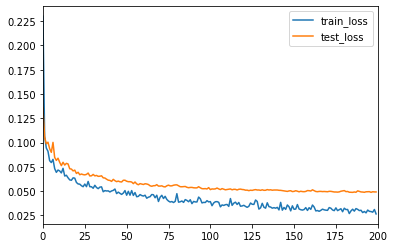

In [11]:
plt.xlim(0, 200)
plt.plot(train_losses, label="train_loss")
plt.plot(test_losses, label="test_loss")
plt.legend()
plt.show()

In [12]:
def calc_iou(xyxy_1, xyxy_2):
    #重なり合う部分がないとき、0をリターン
    if xyxy_1["xmax"] < xyxy_2["xmin"]:
        return 0.
    if xyxy_1["xmin"] > xyxy_2["xmax"]:
        return 0.
    if xyxy_1["ymax"] < xyxy_2["ymin"]:
        return 0.
    if xyxy_1["ymin"] > xyxy_2["ymax"]:
        return 0.
    
    #それぞれのbdの面積を計算
    area_1 = (xyxy_1["xmax"] - xyxy_1["xmin"]) * (xyxy_1["ymax"] - xyxy_1["ymin"])
    area_2 = (xyxy_2["xmax"] - xyxy_2["xmin"]) * (xyxy_2["ymax"] - xyxy_2["ymin"])
    
    #intersection部分の面積計算に必要な座標を計算
    xmin = max(xyxy_1["xmin"], xyxy_2["xmin"])
    ymin = max(xyxy_1["ymin"], xyxy_2["ymin"])
    xmax = min(xyxy_1["xmax"], xyxy_2["xmax"])
    ymax = min(xyxy_1["ymax"], xyxy_2["ymax"])
    
    area_inter = (xmax - xmin) * (ymax - ymin)
    area_union = area_1 + area_2 - area_inter
    
    return area_inter / area_union


def non_max_supression(scores, xyxys, thres=0.4):
    if len(xyxys) <= 1:
        return scores, xyxys
    
    #重複を許さない2つの数のインデックスを作成
    array = [i for i in range(len(xyxys))]
    combs = itertools.combinations(array, 2)
    
    flags = [True for i in range(len(xyxys))]

    for i, j in combs:
        iou = calc_iou(xyxys[i], xyxys[j])
        #iouが小さい方をFalse
        if iou > thres:
            if scores[i] > scores[j]:
                flags[j] = False
            else:
                flags[i] = False
    
    res_scores, res_xyxyxs = list(), list()
    
    #Falseに分類されたものを削除
    for i, flag in enumerate(flags):
        if flag is True:
            res_scores.append(scores[i])
            res_xyxyxs.append(xyxys[i])
            
    return res_scores, res_xyxyxs

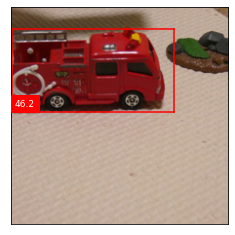

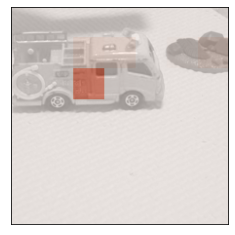

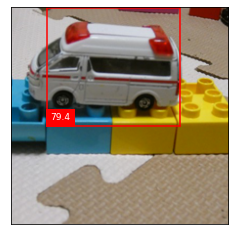

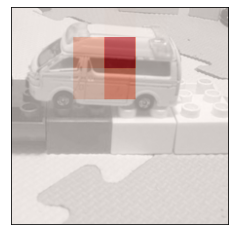

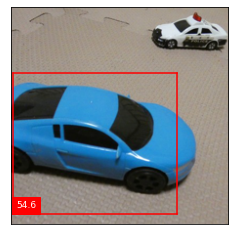

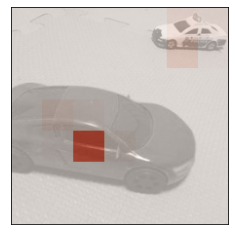

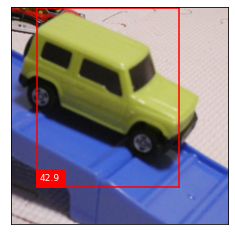

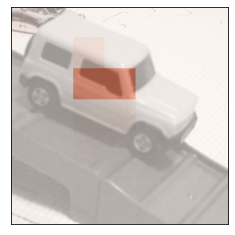

In [14]:
net.to_cpu()
test_loader.to_cpu()
train_loader.to_cpu()

for imgs, targets in test_loader:
    pred = net(imgs)
    
    for i in range(4):
        scores, pred_bnds = convert_pred_to_xywh(pred[i, :, :, :].data, 
                                                 thres=0.25)
        pred_bnds = convert_xywhs_to_xyxys(pred_bnds)
        scores, pred_bnds = non_max_supression(scores, pred_bnds, thres=0.3)
        tmp_img = convert_img_for_mat(imgs[i])
        
        write_bndbox(tmp_img, pred_bnds, scores=scores, ticks=False)
        show_heatmap(tmp_img, pred[i, 0, :, :].data, ticks=False)
    break
        #print(np.round(100 * pred[i, 0, :, :].data, 0))